# A Physics-Informed Neural Network approach for compartmental epidemiological models


Notebooks for PINN solution of the SIR compartmental model presented [in the paper](https://arxiv.org/abs/2311.09944):

```
@misc{millevoi2023physicsinformed,
      title={A Physics-Informed Neural Network approach for compartmental epidemiological models}, 
      author={Caterina Millevoi and Damiano Pasetto and Massimiliano Ferronato},
      year={2023},
      eprint={2311.09944},
      archivePrefix={arXiv},
      primaryClass={math.NA}
}
```

Note: The uploaded code is related to Case 4 and Case 5. For further information please contact the corresponding author.

In [ ]:
import sciann as sn
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## Case 4: Synthetic $\mathcal{R}_t$ with large data errors

In [2]:
df_SIR = pd.read_table("./Case4.txt")
df_SIR

,Date,Infectious,I data,Rt,sigma,H data
0,2020-02-01,1.000000,5744.0,2.998788,0.227456,0.0
1,2020-02-02,1.491552,0.0,2.998676,0.227450,0.0
2,2020-02-03,2.224363,0.0,2.998534,0.227443,0.0
3,2020-02-04,3.317592,22952.0,2.998308,0.227435,0.0
4,2020-02-05,4.947367,0.0,2.997910,0.227426,0.0
...,...,...,...,...,...,...
115,2020-05-26,693.744700,0.0,0.385698,0.097585,12.0
116,2020-05-27,615.155300,0.0,0.407638,0.097574,11.0
117,2020-05-28,546.837700,9532.0,0.404954,0.097565,10.0
118,2020-05-29,484.814100,0.0,0.382471,0.097557,9.0


In [3]:
# SIR parameters
N     = 56e6 # (-) population (Italy)
delta = 1/5  # (1/T) 5 = mean reproduction period 

In [4]:
# Time domain
timespan = df_SIR["Date"].values.astype('datetime64[D]')

t0 = 0.                 # (days) initial time
tf = len(timespan)      # (days) final time

t_data = np.arange(t0,tf)
t_test = np.arange(t0,tf,0.1)

In [5]:
# Scaling factors
SI = 1e5
SH = 1e3

C = SI*delta/SH

In [6]:
# Infectious data and reproduction number
I_data = df_SIR["Infectious"].values
I_obs  = df_SIR["I data"].values
Rt_data = df_SIR["Rt"].values
sigma_data = df_SIR["sigma"].values

# Hospitaliation data
H_data = (delta*sigma_data*I_data).reshape(-1,)
H_obs = df_SIR["H data"].values

I_obs_sc  = I_obs/SI
I_data_sc = I_data/SI
H_obs_sc  = H_obs/SH
H_data_sc = H_data/SH
t_data_sc = t_data/tf
t_test_sc = t_test/tf

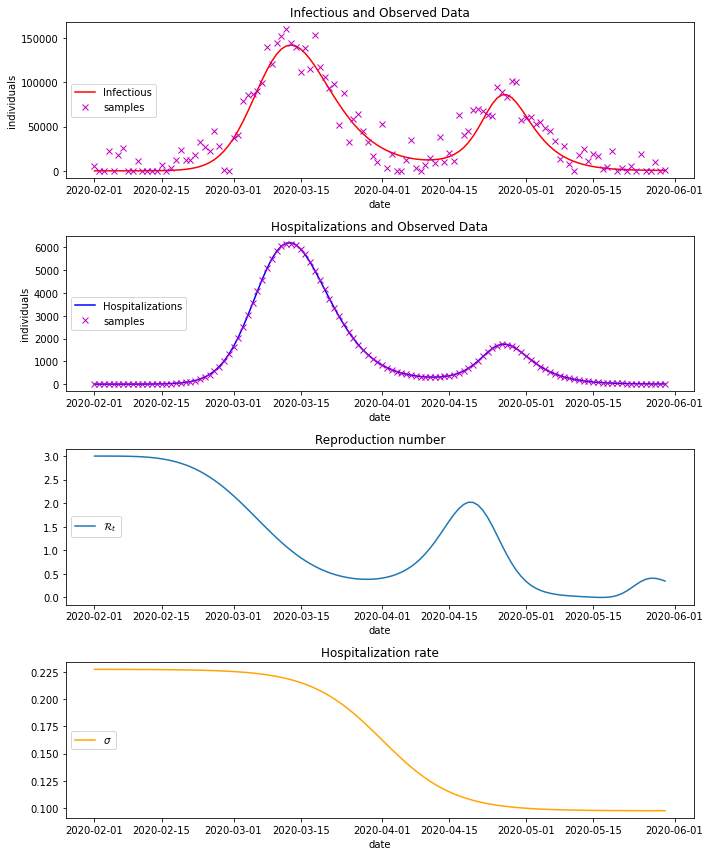

In [7]:
# Plot results
fig, ax = plt.subplots(4, 1, figsize=(10,12))

ax[0].plot(timespan, I_data, 'r', label='Infectious')
ax[0].plot(timespan, I_obs, 'xm', label='samples')
ax[0].legend(loc=6)
ax[0].set_xlabel('date')
ax[0].set_ylabel('individuals')
ax[0].set_title('Infectious and Observed Data')

ax[1].plot(timespan, H_data, 'b', label='Hospitalizations')
ax[1].plot(timespan, H_obs, 'xm', label='samples')
ax[1].legend(loc=6)
ax[1].set_xlabel('date')
ax[1].set_ylabel('individuals')
ax[1].set_title('Hospitalizations and Observed Data')

ax[2].plot(timespan, Rt_data, label=r"$\mathcal{R}_t$")
ax[2].legend(loc=6)
ax[2].set_xlabel('date')
ax[2].set_title('Reproduction number')

ax[3].plot(timespan,sigma_data, 'orange', label=r"$\sigma$")
ax[3].legend(loc=6)
ax[3].set_xlabel('date')
ax[3].set_title('Hospitalization rate')

fig.tight_layout()

plt.show()

In [8]:
# Training parameters
loss_err  = 'mse'
optimizer = 'adam'

### Joint

In [9]:
sn.reset_session()

In [10]:
# Set random seed for reproducible results
sn.set_random_seed(34)

In [11]:
# Build NN - Joint
ts  = sn.Variable("ts")
Is = sn.Functional("Is", ts, 4*[50], output_activation='square')

Rt = sn.Functional("Rt", ts, 4*[100], output_activation='square')

In [12]:
# ODE
L_dIdt = sn.rename((sn.diff(Is,ts)-tf*delta*(Rt-1)*Is), "L_dIdt")

In [13]:
loss_joint = [sn.PDE(L_dIdt), sn.Data(Rt*0.0), sn.Data(Is)]

In [14]:
m = sn.SciModel(ts, loss_joint, loss_err, optimizer)

In [15]:
# Training points
Nc = 6000    # collocation points

I_obs_sc = I_obs_sc.reshape(-1,1)
t_train_ode = np.random.uniform(t0/tf, 1., Nc-1)
t_train_ode = np.insert(t_train_ode,0,0.0)
t_train = np.concatenate([t_data_sc.reshape(-1,1), t_train_ode.reshape(-1,1)])
ids_data = np.arange(t_data_sc.size, dtype=np.intp)

In [16]:
loss_train   = ['zeros']*2+[(ids_data,I_obs_sc)]
epochs_joint = 5000
batch_size   = 100

In [ ]:
# Train the model
time1 = time.time()
h     = m.train(t_train,
                loss_train,
                epochs=epochs_joint,
                batch_size=batch_size,
                verbose=1
               )
time2 = time.time()

In [18]:
print(f'Training time: {time2-time1}')

Training time: 1641.0756912231445


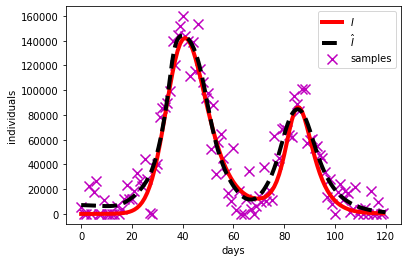

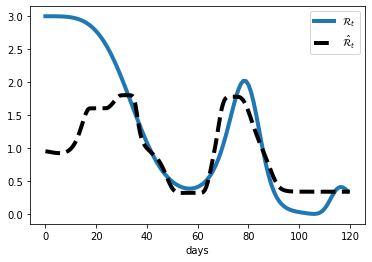

In [19]:
# Get predictions
I_pred_test = Is.eval(m, t_test_sc)*SI
Rt_pred_test = Rt.eval(m, t_test_sc)

# Plot results
plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,I_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$I$',r'$\hat{I}$','samples'])
plt.show()

plt.plot(t_data, Rt_data, linewidth=4)
plt.plot(t_test, Rt_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\mathcal{R}_t$', r'$\hat{\mathcal{R}}_t$'])
plt.show()

In [20]:
# Evaluate errors
I_pred = Is.eval(m, t_data_sc)*SI
Rt_pred = Rt.eval(m, t_data_sc)

I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
Rt_err = np.linalg.norm(Rt_data-Rt_pred,2)/np.linalg.norm(Rt_data,2)
Rt_err100 = np.linalg.norm(Rt_data[20:]-Rt_pred[20:],2)/np.linalg.norm(Rt_data[20:],2)


print(f'I error: {I_err:.3e}')
print(f'Rt error: {Rt_err:.3e}')
print(f'Rt error last 100 days: {Rt_err100:.3e}')

I error: 1.312e-01
Rt error: 5.008e-01
Rt error last 100 days: 2.932e-01


### Split

In [21]:
sn.reset_session()

In [22]:
# Set random seed for reproducible results
sn.set_random_seed(34)

In [23]:
# Build NN - Split - only data regression
ts  = sn.Variable("ts")
Isc = sn.Functional("Isc", ts, 4*[50], output_activation='square')

In [24]:
# Build the model - Split - only data regression
loss_data = sn.Data(Isc)

m_data = sn.SciModel(ts, loss_data, loss_err, optimizer)

In [25]:
t_data_train = t_data_sc
epochs_data  = 1000
batch_data   = 10

In [ ]:
# Train the model - Split - only data regression
time1_data = time.time()
h_data     = m_data.train(t_data_train, 
                          I_obs_sc, 
                          epochs=epochs_data,
                          batch_size=batch_data,
                          verbose=1)
time2_data = time.time()

In [27]:
print(f'Training time: {time2_data-time1_data}')

Training time: 109.45642733573914


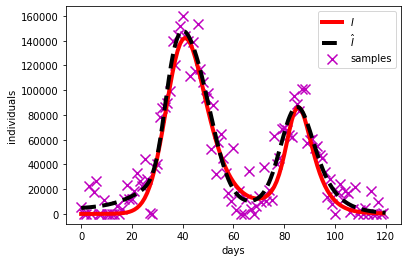

In [28]:
# Get predictions
Isc_pred = Isc.eval(m_data, t_test_sc)

# Plot results
plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,Isc_pred*SI, '--', c='k', linewidth=4)
plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$I$','$\hat{I}$','samples'])
plt.show()

In [29]:
# Evaluate errors
Isc_pred = Isc.eval(m_data,t_data_sc)
Isc_err = np.linalg.norm(I_data_sc-Isc_pred,2)/np.linalg.norm(I_data_sc,2)
print(f'Isc error: {Isc_err:.3e}')

Isc error: 1.357e-01


In [30]:
# Fix the I-NN weights
Isc_weights = Isc.get_weights()

Is = sn.Functional("Is", ts, 4*[50], output_activation='square', trainable=False)
Is.set_weights(Isc_weights)

In [31]:
# Build NN - Split - fully physics-informed
Rt = sn.Functional("Rt", ts, 4*[100], output_activation='square')

In [32]:
# ODE
L_dIdt = sn.rename((sn.diff(Is,ts)-tf*delta*(Rt-1)*Is), "L_dIdt")

In [33]:
# Build the model - Split - fully physics-informed
loss_ode = [sn.PDE(L_dIdt), sn.Data(Rt*0.0), sn.Data(Is*0.0)]

m_ode = sn.SciModel(ts, loss_ode, loss_err, optimizer)

loss_train_ode = ['zeros']*3

epochs_ode = 3000

In [ ]:
# Train the model - Split - fully physics-informed
time1_ode = time.time()
h_ode     = m_ode.train(t_train_ode,
                        loss_train_ode,
                        epochs=epochs_ode,
                        batch_size=batch_size,
                        verbose=1)
time2_ode = time.time()

In [35]:
print(f'Training time: {time2_ode-time1_ode}')

Training time: 993.7804155349731


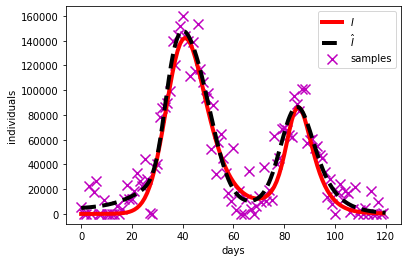

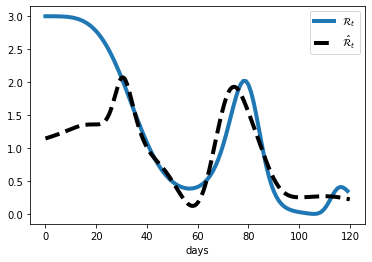

In [36]:
# Get predictions
I_pred_test = Is.eval(m_ode, t_test_sc)*SI
Rt_pred_test = Rt.eval(m_ode, t_test_sc)

# Plot results
plt.plot(t_data, I_data, c='r', linewidth=4)
plt.plot(t_test, I_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data, I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$I$',r'$\hat{I}$',r'samples'])
plt.show()

plt.plot(t_data, Rt_data, linewidth=4)
plt.plot(t_test, Rt_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\mathcal{R}_t$', r'$\hat{\mathcal{R}}_t$'])
plt.show()

In [37]:
# Evaluate errors
I_pred = Is.eval(m_ode, t_data_sc)*SI
Rt_pred = Rt.eval(m_ode, t_data_sc)

I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
Rt_err = np.linalg.norm(Rt_data-Rt_pred,2)/np.linalg.norm(Rt_data,2)
Rt_err100 = np.linalg.norm(Rt_data[20:]-Rt_pred[20:],2)/np.linalg.norm(Rt_data[20:],2)

print(f'I error: {I_err:.3e}')
print(f'Rt error: {Rt_err:.3e}')
print(f'Rt error last 100 days: {Rt_err100:.3e}')

I error: 1.357e-01
Rt error: 4.734e-01
Rt error last 100 days: 3.189e-01


## Case 5: synthetic data of infections and hospitalizations

### Joint

In [38]:
# Set random seed for reproducible results
sn.set_random_seed(34)

In [39]:
sn.reset_session()

In [40]:
# Build NN - Joint
ts  = sn.Variable("ts")
Is = sn.Functional("Is", ts, 4*[50], output_activation='square')

Rt = sn.Functional("Rt", ts, 4*[100], output_activation='square')
sigma = sn.Functional("sigma", ts, 10*[5], output_activation='square')

In [41]:
# ODE
L_dIdt = sn.rename((sn.diff(Is,ts)-tf*delta*(Rt-1)*Is), "L_dIdt")
deltaHs = sn.rename(sigma*Is*C, "deltaHs")

In [42]:
loss_joint = [sn.PDE(L_dIdt), sn.Data(Rt*0.0), 
              sn.Data(Is), sn.Data(deltaHs)]

In [43]:
m = sn.SciModel(ts, loss_joint, loss_err, optimizer)

In [44]:
# Training points
Nc = 6000    # collocation points

I_obs_sc = I_obs_sc.reshape(-1,1)
H_obs_sc = H_obs_sc.reshape(-1,1)
t_train_ode = np.random.uniform(t0/tf, 1., Nc-1)
t_train_ode = np.insert(t_train_ode,0,0.0)
t_train = np.concatenate([t_data_sc.reshape(-1,1), t_train_ode.reshape(-1,1)])
ids_data = np.arange(t_data_sc.size, dtype=np.intp)

In [45]:
loss_train   = ['zeros']*2+[(ids_data,I_obs_sc),(ids_data,H_obs_sc)]
epochs_joint = 5000
batch_size   = 100

In [ ]:
# Train the model
time1 = time.time()
h     = m.train(t_train,
                loss_train,
                epochs=epochs_joint,
                batch_size=batch_size,
                verbose=1
               )
time2 = time.time()

In [47]:
print(f'Training time: {time2-time1}')

Training time: 1799.1056983470917


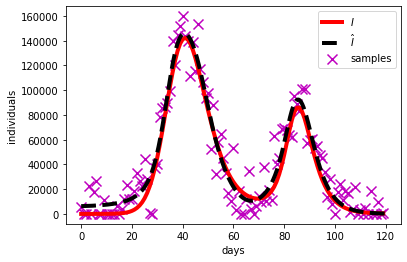

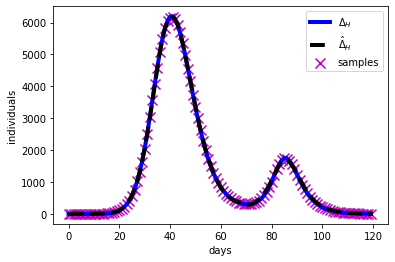

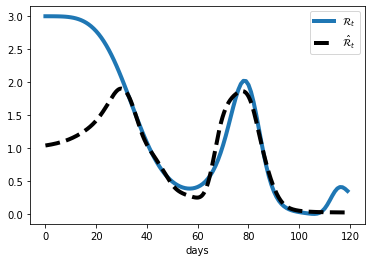

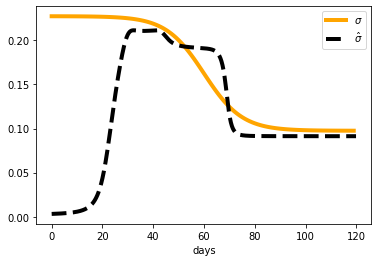

In [48]:
# Get predictions
I_pred_test = Is.eval(m, t_test_sc)*SI
deltaH_pred_test = deltaHs.eval(m, t_test_sc)*SH
Rt_pred_test = Rt.eval(m, t_test_sc)
sigma_pred_test = sigma.eval(m, t_test_sc)

# Plot results
plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,I_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$I$',r'$\hat{I}$','samples'])
plt.show()

plt.plot(t_data,H_data, c='b', linewidth=4)
plt.plot(t_test,deltaH_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,H_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$\Delta_H$',r'$\hat{\Delta}_H$','samples'])
plt.show()

plt.plot(t_data, Rt_data, linewidth=4)
plt.plot(t_test, Rt_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\mathcal{R}_t$', r'$\hat{\mathcal{R}}_t$'])
plt.show()

plt.plot(t_data, sigma_data, c='orange', linewidth=4)
plt.plot(t_test, sigma_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\sigma$', r'$\hat{\sigma}$'])
plt.show()

In [49]:
# Evaluate errors
I_pred = Is.eval(m, t_data_sc)*SI
deltaH_pred = deltaHs.eval(m, t_data_sc)*SH
Rt_pred = Rt.eval(m, t_data_sc)
sigma_pred = sigma.eval(m, t_data_sc)

I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
deltaH_err = np.linalg.norm(H_data-deltaH_pred,2)/np.linalg.norm(H_data,2)
Rt_err = np.linalg.norm(Rt_data-Rt_pred,2)/np.linalg.norm(Rt_data,2)
Rt_err100 = np.linalg.norm(Rt_data[20:]-Rt_pred[20:],2)/np.linalg.norm(Rt_data[20:],2)
sigma_err = np.linalg.norm(sigma_data-sigma_pred,2)/np.linalg.norm(sigma_data,2)
sigma_err100 = np.linalg.norm(sigma_data[20:]-sigma_pred[20:],2)/np.linalg.norm(sigma_data[20:],2)


print(f'I error: {I_err:.3e}')
print(f'DeltaH error: {deltaH_err:.3e}')
print(f'Rt error: {Rt_err:.3e}')
print(f'Rt error last 100 days: {Rt_err100:.3e}')
print(f'sigma error: {sigma_err:.3e}')
print(f'sigma error last 100 days: {sigma_err100:.3e}')

I error: 1.019e-01
DeltaH error: 1.041e-02
Rt error: 4.842e-01
Rt error last 100 days: 2.679e-01
sigma error: 5.576e-01
sigma error last 100 days: 2.472e-01


### Split

In [50]:
sn.reset_session()

In [51]:
# Set random seed for reproducible results
sn.set_random_seed(34)

In [52]:
# Build NN - Split - only data regression
ts  = sn.Variable("ts")
Hsc = sn.Functional("Hsc", ts, 4*[100], output_activation='square')

In [53]:
# Build the model - Split - only data regression
loss_data = sn.Data(Hsc)

m_data = sn.SciModel(ts, loss_data, loss_err, optimizer)

In [54]:
t_data_train = t_data_sc
epochs_data  = 3000
batch_data   = 10

In [ ]:
# Train the model - Split - only data regression
time1_data = time.time()
h_data     = m_data.train(t_data_train, 
                          H_obs_sc, 
                          epochs=epochs_data,
                          batch_size=batch_data,
                          verbose=1)
time2_data = time.time()

In [56]:
print(f'Training time: {time2_data-time1_data}')

Training time: 328.13727164268494


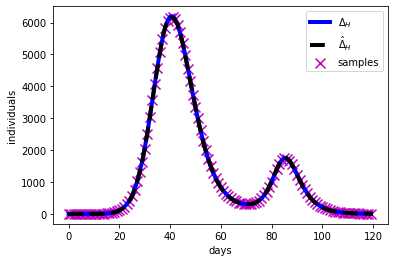

In [57]:
# Get predictions
Hsc_pred = Hsc.eval(m_data, t_test_sc)

# Plot results
plt.plot(t_data,H_data, c='b', linewidth=4)
plt.plot(t_test,Hsc_pred*SH, '--', c='k', linewidth=4)
plt.scatter(t_data,H_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$\Delta_H$','$\hat{\Delta}_H$','samples'])
plt.show()

In [58]:
# Evaluate errors
Hsc_pred = Hsc.eval(m_data,t_data_sc)
Hsc_err = np.linalg.norm(H_data_sc-Hsc_pred,2)/np.linalg.norm(H_data_sc,2)
print(f'Hsc error: {Hsc_err:.3e}')

Hsc error: 4.543e-03


In [60]:
# Fix the H-NN weights
Hsc_weights = Hsc.get_weights()

deltaHs = sn.Functional("deltaHs", ts, 4*[100], output_activation='square', trainable=False)
deltaHs.set_weights(Hsc_weights)

In [61]:
# Build NN - Split - fully physics-informed
Rt = sn.Functional("Rt", ts, 4*[100], output_activation='square')
sigma = sn.Functional("sigma", ts, 10*[5], output_activation='square')

c=1/C
Is = sn.rename(c*deltaHs*sigma, "Is")

In [62]:
# ODE
L_dIdt = sn.rename((sn.diff(Is,ts)-tf*delta*(Rt-1)*Is), "L_dIdt")

In [63]:
# Build the model - Split - fully physics-informed
loss_ode = [sn.PDE(L_dIdt), sn.Data(Rt*0.0), sn.Data(sigma*0.0),# sn.Data(deltaHs*0.0),
            sn.Data(Is)]

m_ode = sn.SciModel(ts, loss_ode, loss_err, optimizer)

loss_train_ode = ['zeros']*3+[(ids_data,I_obs_sc)]

epochs_ode = 1000

In [ ]:
# Train the model - Split - fully physics-informed
time1_ode = time.time()
h_ode     = m_ode.train(t_train,
                        loss_train_ode,
                        epochs=epochs_ode,
                        batch_size=batch_size,
                        verbose=1)
time2_ode = time.time()

In [65]:
print(f'Training time: {time2_ode-time1_ode}')

Training time: 439.902006149292


In [66]:
# Get predictions
I_pred_test = Is.eval(m_ode, t_test_sc)*SI
Rt_pred_test = Rt.eval(m_ode, t_test_sc)
sigma_pred_test = sigma.eval(m_ode, t_test_sc)
sigma_pred_test = 1/sigma_pred_test
deltaH_pred_test = deltaHs.eval(m_ode, t_test_sc)*SH

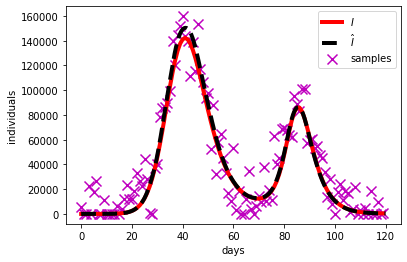

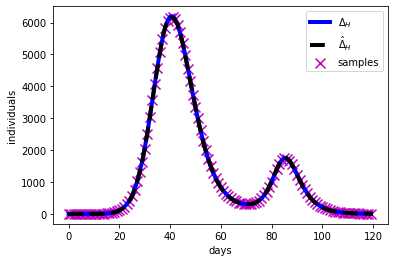

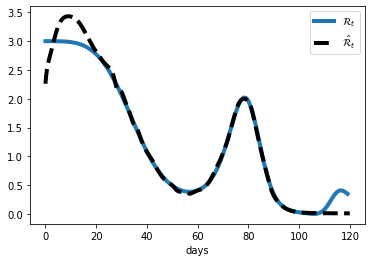

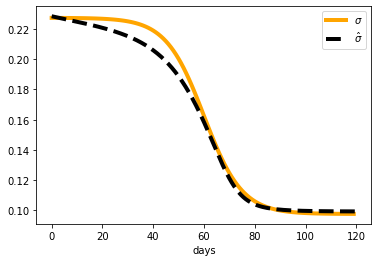

In [67]:
# Plot results
plt.plot(t_data, I_data, c='r', linewidth=4)
plt.plot(t_test, I_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data, I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$I$',r'$\hat{I}$',r'samples'])
plt.show()

plt.plot(t_data,H_data, c='b', linewidth=4)
plt.plot(t_test,deltaH_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,H_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$\Delta_H$',r'$\hat{\Delta}_H$','samples'])
plt.show()

plt.plot(t_data, Rt_data, linewidth=4)
plt.plot(t_test, Rt_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\mathcal{R}_t$', r'$\hat{\mathcal{R}}_t$'])
plt.show()

plt.plot(t_data, sigma_data, c='orange', linewidth=4)
plt.plot(t_test, sigma_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\sigma$', r'$\hat{\sigma}$'])
plt.show()

In [68]:
# Evaluate errors
I_pred = Is.eval(m_ode, t_data_sc)*SI
Rt_pred = Rt.eval(m_ode, t_data_sc)
sigma_pred = sigma.eval(m_ode, t_data_sc)
sigma_pred = 1/sigma_pred
deltaH_pred = deltaHs.eval(m_ode, t_data_sc)*SH

I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
deltaH_err = np.linalg.norm(H_data-deltaH_pred,2)/np.linalg.norm(H_data,2)
Rt_err = np.linalg.norm(Rt_data-Rt_pred,2)/np.linalg.norm(Rt_data,2)
Rt_err100 = np.linalg.norm(Rt_data[20:]-Rt_pred[20:],2)/np.linalg.norm(Rt_data[20:],2)
sigma_err = np.linalg.norm(sigma_data-sigma_pred,2)/np.linalg.norm(sigma_data,2)
sigma_err100 = np.linalg.norm(sigma_data[20:]-sigma_pred[20:],2)/np.linalg.norm(sigma_data[20:],2)


print(f'I error: {I_err:.3e}')
print(f'DeltaH error: {deltaH_err:.3e}')
print(f'Rt error: {Rt_err:.3e}')
print(f'Rt error last 100 days: {Rt_err100:.3e}')
print(f'sigma error: {sigma_err:.3e}')
print(f'sigma error last 100 days: {sigma_err100:.3e}')

I error: 5.270e-02
DeltaH error: 4.543e-03
Rt error: 1.037e-01
Rt error last 100 days: 8.197e-02
sigma error: 3.687e-02
sigma error last 100 days: 4.290e-02
